In [1]:
import pandas as pd
import emoji
import re 
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# packages for text processing
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('wordnet')

# Google Sheet with crypto lexicon and stopwords
sheet_id = '1Eogaz6-_5xuJ5c97XWerS7s9ps4xWyNBLd964yCWBz4'

Pick up the pickle from the data acquistion code

In [2]:
df_raw = pd.read_pickle('data/reddit_extract.pkl')
df_raw['comment'] = df_raw['comment'].str.lower()

Get custom crypto lexicon from GSheets

In [3]:
sheet_name = 'lexicon'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
lex_raw = pd.read_csv(url)
crypto_words = dict(lex_raw.values)

Initialize Sentiment Intensity Analyzer and update with custom crypto slang.

In [4]:
sia = SIA()
sia.lexicon.update(crypto_words)

Loop through comments, create sentiment score and save in dataframe

In [5]:
df_collect = pd.DataFrame()

for sub in df_raw['sub'].unique().tolist() :
    results = []

    # create list from the comments in dataframe for selected submission
    comment_str_raw = df_raw[df_raw['sub']==sub]['comment'].tolist()

    # remove emoji
    comment_str_noemoji = [emoji.get_emoji_regexp().sub(u'',comment).lower() for comment in comment_str_raw] 
    comment_str_noemoji

    # create polarity score
    for comment in comment_str_noemoji :
        comment = comment.replace("\n", "")
        pol_score = sia.polarity_scores(comment)
        pol_score['comment'] = comment
        results.append(pol_score)

    df = pd.DataFrame(results)  
    df['sub'] = sub
    
    df_collect = df_collect.append(df)

Classify each comment as positive (=1), neutral (=0), or negative (-1)

In [6]:
thresh = .1

df_collect['label'] = 'neu'
df_collect.loc[df_collect['compound'] > 1*thresh, 'label'] = 'pos'
df_collect.loc[df_collect['compound'] < -1*thresh, 'label'] = 'neg'
df_collect.drop(columns=['neg','neu','pos'], inplace=True)
#df_collect.to_csv('data/comments_scored.csv', index=False)

df_collect.groupby(['sub'])['label'].value_counts(normalize=True).unstack(fill_value=0)

label,neg,neu,pos
sub,,,
p9o1td,0.155181,0.405783,0.439036
qcekzf,0.208941,0.336752,0.454306
r9t7ks,0.271646,0.322803,0.405551
rylwuh,0.279263,0.327142,0.393595


Clean up comments by tokenizing and lemmatizing. Note that this does not do a great job with contractions, for example <i>don't</i> appears as <i>don</i> and <i>t</i>. I clean this up with stopwords.

In [7]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df_collect2 = df_collect.copy()
df_collect2['comment_lemmatized'] = df_collect2['comment'].apply(lemmatize_text)
df_collect2['comment_lemmatized_string'] = [' '.join(map(str, l)) for l in df_collect2['comment_lemmatized']]
df_collect2.drop(columns=['comment_lemmatized','comment'], inplace=True)
df_collect2.rename(columns={'comment_lemmatized_string':'comment_cleaned'}, inplace=True)

Get custom stopwords from the same GSheet document as lexicon above.

In [8]:
sheet_name = 'stopwords'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
stop_raw = pd.read_csv(url, header=None)
all_stopwords = list(STOPWORDS) + stop_raw[0].tolist()

Function to make a word cloud. Pass in the reddit thread ID, the desired sentiment (pos or neg), and the desired colormap.

In [9]:
def make_cloud(sub, sent, color) :
    text = (" ").join(df_collect2[df_collect2['sub']==sub]['comment_cleaned'])

    #create the wordcloud object
    wordcloud = WordCloud(stopwords = all_stopwords, width=800, height=600, max_words=30, colormap=color,
                      collocations=True).generate(text)

    #plot the wordcloud object
    plt.figure(figsize = (8,6))
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.savefig('img/wordcloud_'+sent+'.png')
    plt.show()

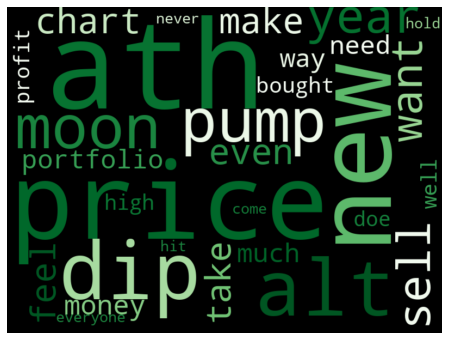

In [10]:
make_cloud('qcekzf','pos','Greens')

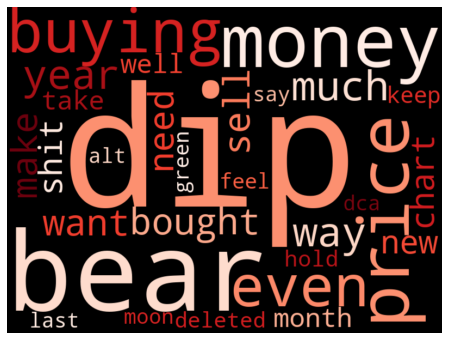

In [11]:
make_cloud('rylwuh','neg','Reds')